## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        data_path = os.path.join(os.getcwd(), data_path)
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

We now want to compute the datasets mean and std. Since neural nets are sensitive to the input scale of the dataset such as the scale of the RGB channels.

This should ensure that each channel (R,G,B) are centered around zero with unit variance and should stabilize our training and make the optimizer more predictable.


We need first to design a transformer which will resize all the images to the IMG_SIZE. We did this to ensure that the input dimensions are uniform and we have picked 224 for the IMG_SIZE as it is very common and people on the internet say it is a good balance between image detail and not getting the GPU on fire.


In [4]:
IMG_SIZE = 224

stats_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])


Now let's assign a batch size (96 works quite well on this GPU with 8 GB of VRAM -  reduce this number if you get an error about not having enough memory available)
We load the training data and we'll proceed to calculate the mean and std for the whole dataset.

In [5]:

BATCH_SIZE = 96

train_ds_stats = Hotdog_NotHotdog(train=True, transform=stats_transform)
stats_loader = DataLoader(train_ds_stats, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

sum_c = torch.zeros(3, dtype=torch.float64)
sqsum_c = torch.zeros(3, dtype=torch.float64)
count = 0

with torch.no_grad():
    for x, _ in stats_loader:                 # x: [B,3,H,W]
        x = x.to(torch.float64)
        batch_size, channels, height, width = x.shape
        sum_c   += x.sum(dim=[0,2,3])
        sqsum_c += (x * x).sum(dim=[0,2,3])
        count   += batch_size * height * width

mean = (sum_c / count).to(torch.float32)
var  = (sqsum_c / count) - (mean.double() ** 2)
std  = torch.sqrt(var.clamp_min(1e-8)).to(torch.float32)

print("MEAN:", mean.tolist())
print("STD :", std.tolist())


MEAN: [0.5349069237709045, 0.44422993063926697, 0.3525683879852295]
STD : [0.26947343349456787, 0.2638039290904999, 0.2741941511631012]


Let's add the transforms for the training data and for the test data.
We will introduce more randomness in the training data, but we want to keep the test data deterministic, so we will just resize and normalize it.

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
test_transform = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])


trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7958227..2.2467988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9267972..1.646108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.985008..2.361216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7958227..2.1609857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.78127..2.2324965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6066376..2.0179641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.985008..2.3

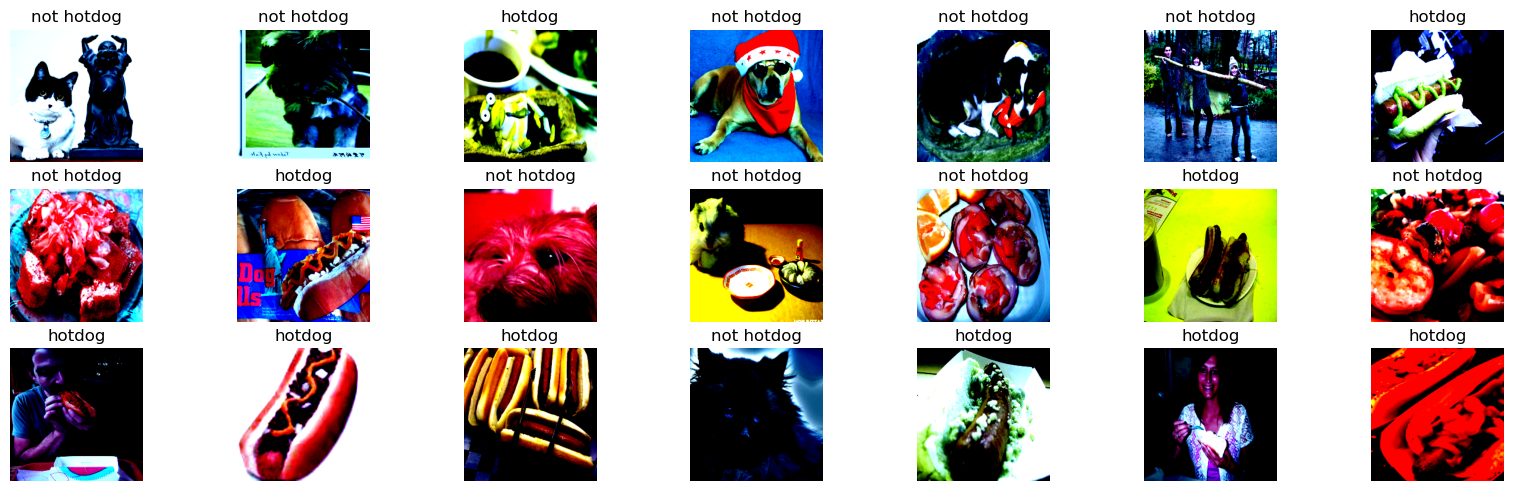

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


plt.show()


Now create a model and train it!


In [8]:
class Network(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # ↓ add pooling early: 224→112
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 112→56
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 56→28
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # keep spatial size here: 28→28
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 28→14
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)         # [B,128,1,1]
        self.fc  = nn.Linear(128, num_classes)     # logits, no Softmax

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)          # [B,128,H,W]
        x = self.block6(x)
        x = self.gap(x).flatten(1)  # [B,128]
        x = nn.Dropout(0.3)(x)
        return self.fc(x)           # logits
    
# class BasicBlock(nn.Module):
#     def __init__(self, cin, cout, stride=1):
#         super().__init__()
#         self.down = None
#         if stride != 1 or cin != cout:
#             self.down = nn.Sequential(nn.Conv2d(cin, cout, 1, stride, bias=False),
#                                       nn.BatchNorm2d(cout))
#         self.f = nn.Sequential(
#             nn.Conv2d(cin, cout, 3, stride, 1, bias=False), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
#             nn.Conv2d(cout, cout, 3, 1, 1, bias=False), nn.BatchNorm2d(cout)
#         )
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         y = self.f(x)
#         if self.down is not None:
#             x = self.down(x)
#         return self.relu(x + y)

# class HotdogResNet(nn.Module):
#     def __init__(self, num_classes=2):
#         super().__init__()
#         self.stem = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
#         )  # 224→112
#         self.stage1 = nn.Sequential(BasicBlock(64, 64), BasicBlock(64, 64))
#         self.stage2 = nn.Sequential(BasicBlock(64, 128, stride=2), BasicBlock(128, 128))   # 112→56
#         self.stage3 = nn.Sequential(BasicBlock(128, 256, stride=2), BasicBlock(256, 256))  # 56→28
#         self.stage4 = nn.Sequential(BasicBlock(256, 512, stride=2), BasicBlock(512, 512)) # 28→14
#         self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(),
#                                   nn.Dropout(0.3), nn.Linear(512, num_classes))
#     def forward(self, x):
#         x = self.stem(x); x = self.stage1(x); x = self.stage2(x); x = self.stage3(x); x = self.stage4(x)
#         return self.head(x)  # logits


In [9]:
model = Network().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


In [10]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    
    use_cuda = device.type == "cuda"
    use_amp  = use_cuda  # flip to False if you want to disable AMP
    scaler   = torch.amp.GradScaler(enabled=use_amp)
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

    if use_cuda:
        torch.backends.cudnn.benchmark = True
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            ctx = torch.amp.autocast(device_type="cuda",dtype=torch.float16) if use_amp else torch.autocast("cpu", enabled=False)
            with ctx:
                logits = model(data)                 # model should return logits, not softmax
                loss   = criterion(logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            #Forward pass your image through the network
            output = model(data)

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        with torch.no_grad():
            ctx = torch.amp.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.autocast("cpu", enabled=False)
            with ctx:
                for data, target in test_loader:
                    data   = data.to(device, non_blocking=True)
                    target = target.to(device, non_blocking=True)
                    logits = model(data)
                    loss   = criterion(logits, target)
                    test_loss.append(loss.item())
                    test_correct += (logits.argmax(1) == target).sum().item()

        out_dict['train_acc'].append(train_correct / len(train_loader.dataset))
        out_dict['test_acc'].append(test_correct / len(test_loader.dataset))
        out_dict['train_loss'].append(float(np.mean(train_loss)))
        out_dict['test_loss'].append(float(np.mean(test_loss)))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.639	 test: 0.621	 Accuracy train: 70.5%	 test: 70.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.559	 test: 0.609	 Accuracy train: 73.7%	 test: 71.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.560	 test: 0.602	 Accuracy train: 74.5%	 test: 71.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.560	 Accuracy train: 76.5%	 test: 73.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.633	 Accuracy train: 77.2%	 test: 72.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.507	 test: 0.536	 Accuracy train: 78.2%	 test: 76.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.498	 test: 0.627	 Accuracy train: 79.1%	 test: 73.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.494	 test: 0.550	 Accuracy train: 79.8%	 test: 77.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.480	 test: 0.524	 Accuracy train: 80.2%	 test: 76.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.494	 test: 0.569	 Accuracy train: 79.7%	 test: 75.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.472	 test: 0.513	 Accuracy train: 81.0%	 test: 77.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.473	 test: 0.539	 Accuracy train: 82.1%	 test: 76.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.463	 test: 0.512	 Accuracy train: 81.4%	 test: 77.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.470	 test: 0.589	 Accuracy train: 81.4%	 test: 77.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.463	 test: 0.587	 Accuracy train: 81.0%	 test: 72.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.463	 test: 0.498	 Accuracy train: 81.1%	 test: 78.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.442	 test: 0.499	 Accuracy train: 82.9%	 test: 79.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.429	 test: 0.505	 Accuracy train: 84.1%	 test: 79.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.432	 test: 0.610	 Accuracy train: 83.9%	 test: 75.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.445	 test: 0.474	 Accuracy train: 83.0%	 test: 79.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.484	 Accuracy train: 83.2%	 test: 79.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.434	 test: 0.524	 Accuracy train: 83.4%	 test: 79.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.423	 test: 0.503	 Accuracy train: 84.2%	 test: 79.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.416	 test: 0.464	 Accuracy train: 84.0%	 test: 79.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.419	 test: 0.467	 Accuracy train: 83.8%	 test: 78.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.481	 Accuracy train: 86.1%	 test: 80.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.496	 Accuracy train: 83.7%	 test: 79.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.414	 test: 0.492	 Accuracy train: 84.5%	 test: 79.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.421	 test: 0.508	 Accuracy train: 84.9%	 test: 78.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.412	 test: 0.508	 Accuracy train: 85.1%	 test: 79.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.401	 test: 0.506	 Accuracy train: 85.3%	 test: 78.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.403	 test: 0.522	 Accuracy train: 85.3%	 test: 80.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.396	 test: 0.470	 Accuracy train: 86.5%	 test: 80.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.470	 Accuracy train: 86.0%	 test: 81.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.397	 test: 0.463	 Accuracy train: 85.6%	 test: 80.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.380	 test: 0.564	 Accuracy train: 86.8%	 test: 79.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.380	 test: 0.474	 Accuracy train: 87.2%	 test: 82.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.371	 test: 0.518	 Accuracy train: 88.4%	 test: 81.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.396	 test: 0.519	 Accuracy train: 86.5%	 test: 78.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.374	 test: 0.488	 Accuracy train: 87.0%	 test: 80.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.362	 test: 0.502	 Accuracy train: 88.9%	 test: 80.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.390	 test: 0.444	 Accuracy train: 85.3%	 test: 82.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.445	 Accuracy train: 86.3%	 test: 82.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.385	 test: 0.485	 Accuracy train: 86.6%	 test: 80.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.361	 test: 0.463	 Accuracy train: 87.5%	 test: 81.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.388	 test: 0.462	 Accuracy train: 87.8%	 test: 81.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.371	 test: 0.451	 Accuracy train: 87.0%	 test: 81.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.356	 test: 0.541	 Accuracy train: 88.3%	 test: 80.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.365	 test: 0.483	 Accuracy train: 88.1%	 test: 82.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.352	 test: 0.451	 Accuracy train: 89.4%	 test: 81.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.368	 test: 0.520	 Accuracy train: 87.1%	 test: 79.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.331	 test: 0.543	 Accuracy train: 90.5%	 test: 80.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.356	 test: 0.466	 Accuracy train: 89.2%	 test: 80.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.348	 test: 0.494	 Accuracy train: 89.5%	 test: 81.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.344	 test: 0.469	 Accuracy train: 89.3%	 test: 82.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.347	 test: 0.486	 Accuracy train: 89.4%	 test: 81.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.343	 test: 0.457	 Accuracy train: 89.4%	 test: 81.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.341	 test: 0.470	 Accuracy train: 89.9%	 test: 80.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.351	 test: 0.437	 Accuracy train: 89.5%	 test: 82.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.343	 test: 0.530	 Accuracy train: 89.8%	 test: 77.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.322	 test: 0.451	 Accuracy train: 90.9%	 test: 82.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.319	 test: 0.449	 Accuracy train: 91.1%	 test: 83.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.338	 test: 0.451	 Accuracy train: 91.0%	 test: 82.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.321	 test: 0.512	 Accuracy train: 90.7%	 test: 80.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.325	 test: 0.531	 Accuracy train: 90.7%	 test: 79.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.302	 test: 0.485	 Accuracy train: 91.4%	 test: 81.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.319	 test: 0.463	 Accuracy train: 91.0%	 test: 81.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.310	 test: 0.473	 Accuracy train: 91.5%	 test: 80.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.303	 test: 0.499	 Accuracy train: 91.9%	 test: 79.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.317	 test: 0.479	 Accuracy train: 90.6%	 test: 82.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.319	 test: 0.514	 Accuracy train: 91.5%	 test: 80.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.314	 test: 0.487	 Accuracy train: 90.9%	 test: 80.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.320	 test: 0.481	 Accuracy train: 90.5%	 test: 82.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.283	 test: 0.512	 Accuracy train: 92.2%	 test: 81.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.302	 test: 0.506	 Accuracy train: 91.7%	 test: 81.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.296	 test: 0.436	 Accuracy train: 92.5%	 test: 84.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.282	 test: 0.480	 Accuracy train: 92.9%	 test: 81.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.282	 test: 0.693	 Accuracy train: 93.6%	 test: 79.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.271	 test: 0.478	 Accuracy train: 93.8%	 test: 83.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.298	 test: 0.565	 Accuracy train: 92.5%	 test: 81.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.282	 test: 0.474	 Accuracy train: 93.6%	 test: 81.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.264	 test: 0.712	 Accuracy train: 94.3%	 test: 77.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.272	 test: 0.464	 Accuracy train: 93.7%	 test: 82.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.290	 test: 0.562	 Accuracy train: 92.2%	 test: 77.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.266	 test: 0.469	 Accuracy train: 94.0%	 test: 82.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.268	 test: 0.472	 Accuracy train: 94.4%	 test: 83.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.254	 test: 0.472	 Accuracy train: 94.3%	 test: 82.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.274	 test: 0.506	 Accuracy train: 94.2%	 test: 80.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.250	 test: 0.478	 Accuracy train: 94.4%	 test: 84.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.247	 test: 0.529	 Accuracy train: 94.4%	 test: 82.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.265	 test: 0.564	 Accuracy train: 94.7%	 test: 81.5%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.253	 test: 0.500	 Accuracy train: 94.6%	 test: 81.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.246	 test: 0.514	 Accuracy train: 95.4%	 test: 81.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.246	 test: 0.440	 Accuracy train: 95.2%	 test: 84.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.266	 test: 0.574	 Accuracy train: 93.9%	 test: 77.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.247	 test: 0.498	 Accuracy train: 95.0%	 test: 82.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.222	 test: 0.511	 Accuracy train: 96.2%	 test: 83.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.231	 test: 0.497	 Accuracy train: 96.2%	 test: 84.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.250	 test: 0.488	 Accuracy train: 94.9%	 test: 82.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.668	 Accuracy train: 96.1%	 test: 78.5%
{'train_acc': [0.7054225696140694, 0.7371763556424035, 0.7449926722032242, 0.7650219833903273, 0.7718612603810454, 0.7821201758671226, 0.7914020517830972, 0.7982413287738154, 0.8021494870542257, 0.7972642892037127, 0.8104543234000977, 0.8207132388861749, 0.8138739618954568, 0.8138739618954568, 0.8099658036150464, 0.810942843185149, 0.8285295554469956, 0.8407425500732779, 0.8387884709330727, 0.8304836345872008, 0.8319491939423547, 0.8339032730825598, 0.8417195896433806, 0.8402540302882266, 0.8378114313629702, 0.8612603810454323, 0.8368343917928676, 0.8451392281387397, 0.84904738641915, 0.8505129457743038, 0.8534440644846116, 0.8529555446995604, 0.8646800195407914, 0.8597948216902784, 0.8558866634098681, 0.8680996580361504, 0.8720078163165608, 0.8842208109428432, 0.8646800195407914, 0.8695652173913043, 0.8891060087933561, 0.8534440644846116, 0.8632144601856375, 0.865657059110894, 0.8749389350268686, 0.8778700537371763, 0.

Text(0, 0.5, 'Accuracy')

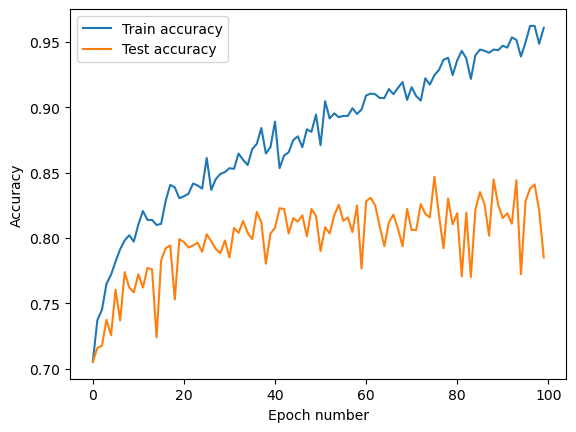

In [11]:
out_dict = train(model, optimizer, num_epochs=100)
print(out_dict)
plt.plot(out_dict['train_acc'], label='Train accuracy')
plt.plot(out_dict['test_acc'], label='Test accuracy')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [14]:
torch.save(model.state_dict(), "dragos_cnn_weights.pth")
torch.save(model, "cnn_model.pth")

In [15]:
torch.save({
    "epoch": 100,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": out_dict['train_loss'][-1],
}, "checkpoint.pth")

# load
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]


/tmp/ipykernel_169638/2690423545.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth")


Text(0, 0.5, 'Loss')

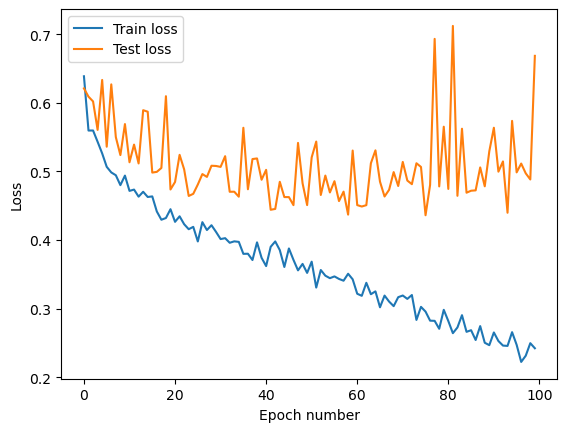

In [12]:
#plotting the loss curves
plt.figure()
plt.plot(out_dict['train_loss'], label='Train loss')
plt.plot(out_dict['test_loss'], label='Test loss')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Loss')

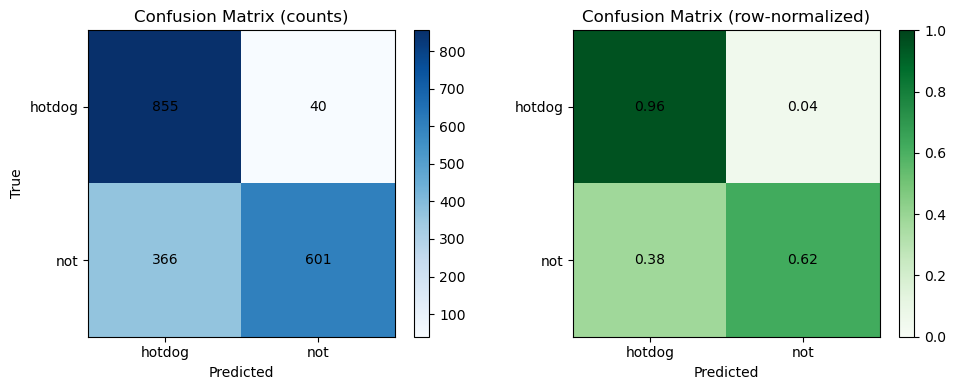

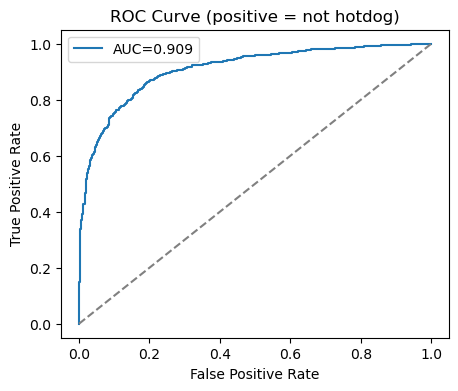

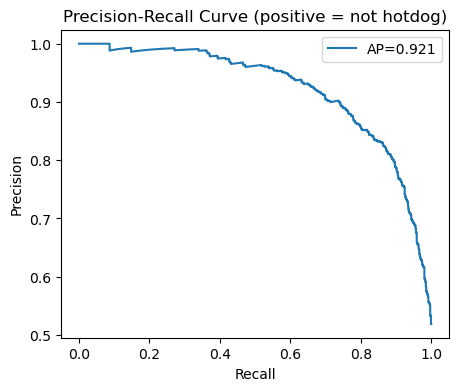

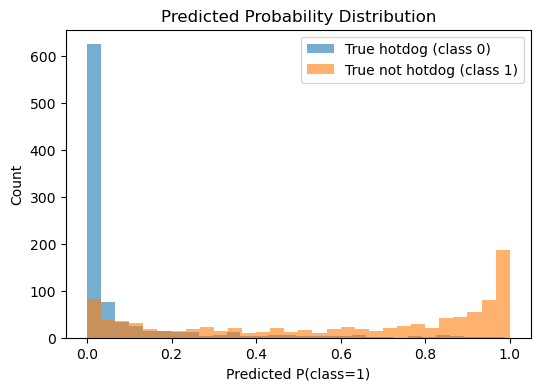

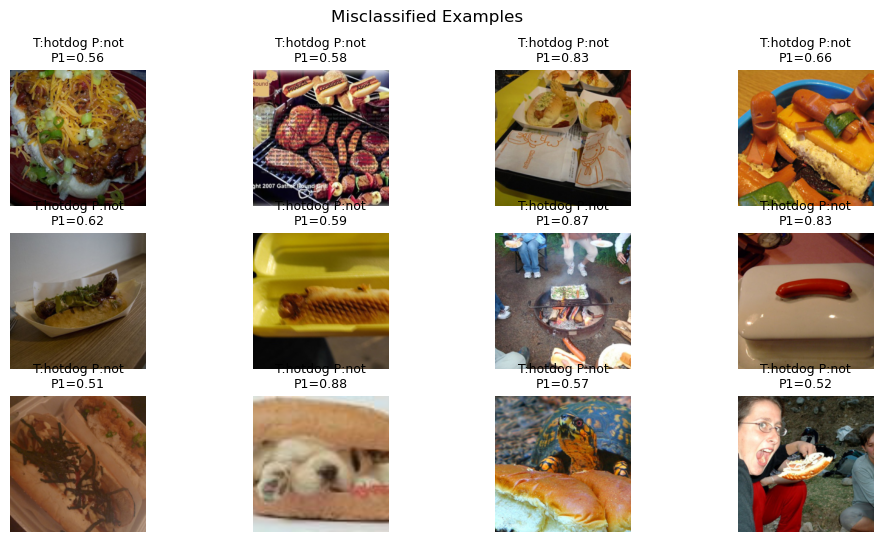

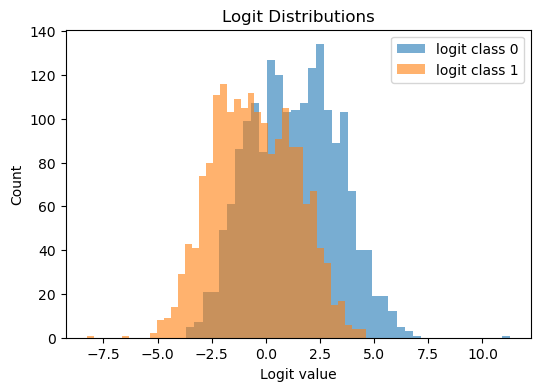

In [16]:
# Additional evaluation & diagnostic plots

import sklearn.metrics as metrics

model.eval()
all_logits = []
all_probs  = []
all_targets = []
all_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        logits = model(data)
        probs  = torch.softmax(logits, dim=1)
        pred   = probs.argmax(1)
        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_targets.append(target)
        all_preds.append(pred.cpu())

logits  = torch.cat(all_logits)
probs   = torch.cat(all_probs)
y_true  = torch.cat(all_targets).numpy()
y_pred  = torch.cat(all_preds).numpy()
prob_pos = probs[:,1].numpy()   # class 1 = "not hotdog" (per earlier title mapping)

# 1. Confusion matrix
cm = torch.zeros(2,2, dtype=torch.int64)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1
cm_norm = cm.float() / cm.sum(dim=1, keepdim=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(cm, cmap='Blues')
ax[0].set_title('Confusion Matrix (counts)')
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, cm[i,j].item(), ha='center', va='center', color='black')
ax[0].set_xticks([0,1]); ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['hotdog','not']); ax[0].set_yticklabels(['hotdog','not'])
ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('True')
plt.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(cm_norm, cmap='Greens', vmin=0, vmax=1)
ax[1].set_title('Confusion Matrix (row-normalized)')
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', color='black')
ax[1].set_xticks([0,1]); ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['hotdog','not']); ax[1].set_yticklabels(['hotdog','not'])
ax[1].set_xlabel('Predicted')
plt.colorbar(im1, ax=ax[1], fraction=0.046)
plt.tight_layout()

# 2. ROC curve & AUC
fpr, tpr, _ = metrics.roc_curve(y_true, prob_pos)
roc_auc = metrics.roc_auc_score(y_true, prob_pos)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (positive = not hotdog)')
plt.legend()

# 3. Precision-Recall curve
prec, rec, _ = metrics.precision_recall_curve(y_true, prob_pos)
ap = metrics.average_precision_score(y_true, prob_pos)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (positive = not hotdog)')
plt.legend()

# 4. Probability histograms
plt.figure(figsize=(6,4))
plt.hist(prob_pos[y_true==0], bins=30, alpha=0.6, label='True hotdog (class 0)')
plt.hist(prob_pos[y_true==1], bins=30, alpha=0.6, label='True not hotdog (class 1)')
plt.xlabel('Predicted P(class=1)')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution')
plt.legend()

# 5. Misclassified examples
mis_idx = [i for i,(t,p) in enumerate(zip(y_true, y_pred)) if t!=p]
num_show = min(12, len(mis_idx))

if num_show > 0:
    # need raw images again (we will pull a subset from test_loader sequentially)
    # collect first num_show misclassified tensors & labels
    collected = []
    with torch.no_grad():
        ptr = 0
        for data, target in test_loader:
            batch = data.cpu()
            for k in range(batch.size(0)):
                if ptr in mis_idx:
                    collected.append((batch[k], target[k].item(), y_pred[ptr], prob_pos[ptr]))
                    if len(collected) == num_show:
                        break
                ptr += 1
            if len(collected) == num_show:
                break

    mean_cpu = mean.view(3,1,1)
    std_cpu  = std.view(3,1,1)

    def denorm(img):
        return (img * std_cpu + mean_cpu).clamp(0,1)

    plt.figure(figsize=(12,6))
    for i,(img, true_lab, pred_lab, ppos) in enumerate(collected):
        plt.subplot(3,4,i+1)
        img_show = denorm(img).permute(1,2,0).numpy()
        plt.imshow(img_show)
        plt.axis('off')
        plt.title(f"T:{['hotdog','not'][true_lab]} P:{['hotdog','not'][pred_lab]}\nP1={ppos:.2f}",
                  fontsize=9)

    plt.suptitle('Misclassified Examples', y=0.98)

# 6. Logit distribution
plt.figure(figsize=(6,4))
plt.hist(logits[:,0].numpy(), bins=40, alpha=0.6, label='logit class 0')
plt.hist(logits[:,1].numpy(), bins=40, alpha=0.6, label='logit class 1')
plt.xlabel('Logit value')
plt.ylabel('Count')
plt.title('Logit Distributions')
plt.legend()

plt.show()